# Project: Data Wrangling and Analysis

#### Setting up the Environment

In [226]:
# This allows modification done to custom modules/packages be captured immediately
%load_ext autoreload
%autoreload 2

In [269]:
# Load necessary packages and modules
import requests
import numpy as np
import pandas as pd
import tweepy
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
from IPython.display import Image
from sqlalchemy import create_engine

from utility.auxiliary import discard_outliers,get_dog
from utility.plotting import plot_period, plot_attributes, plot_attrib

In [2]:
# Set Chart fontsize
mpl.rcParams['font.size'] = 14
plt.style.use('ggplot')


# show full text for columns
#https://stackoverflow.com/questions/68490745/how-to-display-the-full-text-of-a-column-in-pandas

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 4000)

#### Data Gathering

1. Directly download of the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [70]:
twitter_archive = pd.read_csv("twitter_archive_enhanced.csv")

twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

#get response
response = requests.get(url)

#write return to an image
with open("image_predictions.tsv", mode = "wb") as file:
    file.write(response.content)

In [71]:
image_predict = pd.read_csv("image_predictions.tsv", sep='\t')

image_predict.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [43]:
image_predict.shape

(2075, 12)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [244]:
#keys and token to access the API
consumer_key = '0nztgLtDlVtXrnEtYezo3uMxb'
consumer_secret = 'KN0dMHPq0MRVgVrIVhyzPWUSYnVQLqE3tMfuAYQk8DsmdiyDqW'
access_token = '1048815393048018944-ZYhrAbWBvgzDWDrOzzwswbpx6TmDTd'
access_secret = '4szDOoxWqWguuF6t6azjkcL9LV1SqEg6WIYTkBlAVGysp'

#access the API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [14]:
# get all the unique twitter ids in the df
twitter_ids = set(twitter_archive['tweet_id'])

with open("tweet_json.txt", "w") as file:
    for ids in twitter_ids:
        try: 
            #get all the twitter status - using extended mode gives us additional data 
            tweet = api.get_status(ids, tweet_mode = "extended") 
            
            #dump the json data to our file 
            json.dump(tweet._json, file)
            
            #add a linebreak after each dump 
            file.write('\n')
            
        except: 
            continue

In [72]:
api_data = []

#read the created text file
with open("tweet_json.txt", "r") as f:
    for line in f:
        try: 
            tweet = json.loads(line)
            #append a dictionary to the created list            
            api_data.append({
                "tweet_id": tweet["id"],
                "retweet_count": tweet["retweet_count"],
                "favorite_count": tweet["favorite_count"],
                "retweeted": tweet["retweeted"],
                "display_text_range": tweet["display_text_range"]})               
        except:
            print("Error.") 
            
api_data = pd.DataFrame(api_data, columns = ["tweet_id", "retweet_count", "favorite_count", "retweeted", "display_text_range"])
api_data.head()

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range
0,892420643555336193,8805,39404,False,"[0, 85]"
1,892177421306343426,6453,33723,False,"[0, 138]"
2,891815181378084864,4279,25396,False,"[0, 121]"
3,891689557279858688,8890,42753,False,"[0, 79]"
4,891327558926688256,9683,40917,False,"[0, 138]"


In [9]:
api_data.shape

(2351, 5)

### Assessment
In this section, the goal is to detect and document data quality and tidiness issues using visual and programmatic approach.


#### 1. Assessing Twitter Archive Data

In [247]:
# display first 5 data
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [248]:
# display sample of data
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1057,742150209887731712,NaN,NaN,2016-06-13 00:22:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Edmund. He sends stellar selfies. Cute af. 8/10 would totally snapchat with this pupper https://t.co/PprXoqZuKY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/742150209887731712/photo/1,8,10,Edmund,None,None,pupper,None
1484,693231807727280129,NaN,NaN,2016-01-30 00:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bodie. He's not proud of what he did, but it needed to be done. 9/10 eight days was a pretty good streak tbh https://t.co/bpZsGMqVVP",NaN,NaN,NaN,https://twitter.com/dog_rates/status/693231807727280129/photo/1,9,10,Bodie,None,None,None,None
2132,670079681849372674,NaN,NaN,2015-11-27 03:20:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Fabio. He's a wonderful pup. Can't stay away from the devil's lettuce but other than that he's a delight. 10/10 https://t.co/Qvj4JZGdQD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670079681849372674/photo/1,10,10,Fabio,None,None,None,None
1749,679047485189439488,NaN,NaN,2015-12-21 21:15:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This dog doesn't know how to stairs. Quite tragic really. 9/10 get it together pup https://t.co/kTpr9PTMg1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679047485189439488/photo/1,9,10,None,None,None,None,None
1963,673352124999274496,NaN,NaN,2015-12-06 04:03:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",*lets out a tiny screech and then goes into complete cardiac arrest* 12/10 https://t.co/az5PLGzVNJ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673352124999274496/photo/1,12,10,None,None,None,None,None


In [249]:
# display last 5 data
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


Observation from the visual assessment:

* not all tweets could be classified as doggo, floofer, pupper or puppo.
* the source contains unnecessary HTML code
* the `name` columnn contains "None" and some funny characters (e.g 'a')

In [250]:
# Checking if the expanded_urls contains useful information
twitter_archive.expanded_urls.sample(15)

38                                                                      https://twitter.com/dog_rates/status/884925521741709313/photo/1
2004                                                                    https://twitter.com/dog_rates/status/672466075045466113/photo/1
516                                 https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1
2125                                                                    https://twitter.com/dog_rates/status/670361874861563904/photo/1
1625                                                                                                      https://vine.co/v/eEZXZI1rqxX
799                                                                     https://twitter.com/dog_rates/status/772826264096874500/photo/1
2098                                                                    https://twitter.com/dog_rates/status/670727704916926465/photo/1
1780                                            

There seems to be more than 1 expanded url for some tweets. Let's determine tweets with more than one url

In [251]:
# check for two or more urls in the expanded urls
twitter_archive[twitter_archive.expanded_urls.str.contains(',', na = False)].expanded_urls.count()

639

A total of 639 tweets contains more than one url

In [252]:
# Checking for missing data
twitter_archive.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

From the above, it is evident that there is a lot of missing data in the columns regarding the reply and the retweeted status. Since we only want original posts with images, these columns will be dropped before further explorations.

In [253]:
# print a summary of a DataFrame
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The DataType for timestamp is not consistent

In [254]:
# Check for wrong dog name
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

The above shows that there are many inaccurate dog names in the dataset such as `None`, `a`, `the`, `an`.

Let's determine number of tweets withouth a dog 'stage' category 

In [255]:
# Count dogs without category assigned
twitter_archive[twitter_archive.columns[-4:]].apply(lambda x: True if
    all([x[0] == "None", x[1] == "None", x[2] == "None",x[3] =="None"]) else False, axis = 1).value_counts()

True     1976
False     380
dtype: int64

A total of 1976 tweets about the dogs were not categorized

In [256]:
# Checking the text column for data quality
twitter_archive.text.sample(15)

1001     Pls don't send more sherks. I don't care how seemingly floofy they are. It does me so much frighten. Thank u. 11/10 https://t.co/oQqlOsla4R
2032              Say hello to Mark. He's a good dog. Always ready to go for a walk. Excellent posture. 9/10 keep it up Mark https://t.co/m9NleZ1i80
909      This is Beckham. He fell asleep at the wheel. Very churlish. Looks to have a backpup driver tho. That's good. 11/10 https://t.co/rptsOm73Wr
1883          When your entire life is crumbling before you and you're trying really hard to hold your shit together.\n10/10 https://t.co/vqFkgYPCW8
60        This is Bella. She had her first beach experience this morning. Complete success. 12/10 would perform a sandy boop https://t.co/4VsFysDmiw
672                                    This is Ralphy. His dreams were just shattered. Poor pupper. 13/10 it'll be ok Ralphy https://t.co/P0kSN6rT6H
1026                    This is Gustav. He has claimed that plant. It is his now. 10/10 would not try to t

There seems to be float rating. Let's filter this out.

In [257]:
#https://regex101.com/

# Float Pattern of rating
float_pattern = r'\d+\.\d+\/\d+'

twitter_archive[twitter_archive.text.str.contains(float_pattern)] [['tweet_id','text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


These float ratings got transformed to integers at the point of extraction. These are not accurate.

In [258]:
# Checking for retweeted data
twitter_archive.retweeted_status_user_id.notnull().sum()

181

In [259]:
# Checking for response to retweeted data
twitter_archive.in_reply_to_user_id.notnull().sum()

78

In [260]:
#The denominators, which are not 10, are suspicious, so I would like to see look into them closely
twitter_archive.query("rating_denominator != 10 ")[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [261]:
# Filtering out tweets with text having more than one rating pattern

# rating numerator and denominator can be integer or float
pattern = '(\d+(\.\d+)?\/\d+(\.\d+)?)'

twitter_archive[twitter_archive.text.str.count(pattern)!=1][['tweet_id','text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
55,881633300179243008,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17,10
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
561,802624713319034886,"RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12,10
766,777684233540206592,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12,10
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
860,763167063695355904,RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…,8,10
1007,747600769478692864,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,10,10
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


From the above, it is evident that their are retweets in this data. And some tweets have pictures with cat and dog in it.

#### 2. Assessing Twitter Dog Images Prediction Data

In [262]:
# Show first 5 data
image_predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [263]:
# Show last 5 data
image_predict.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [264]:
# display sample of data
image_predict.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
416,674019345211760640,https://pbs.twimg.com/media/CVqZBO8WUAAd931.jpg,1,collie,0.992732,True,borzoi,0.005043,True,Shetland_sheepdog,0.001725,True
1436,773922284943896577,https://pbs.twimg.com/media/Cr2GNdlW8AAbojw.jpg,1,Pomeranian,0.554331,True,Samoyed,0.432158,True,chow,0.003199,True
1733,821407182352777218,https://pbs.twimg.com/ext_tw_video_thumb/821407155391725568/pu/img/AJC07gFJDDBuwNTD.jpg,1,Irish_setter,0.505496,True,vizsla,0.168747,True,Chesapeake_Bay_retriever,0.111311,True
687,684122891630342144,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,1,cheetah,0.822193,False,Arabian_camel,0.046976,False,jaguar,0.025785,False
515,676263575653122048,https://pbs.twimg.com/media/CWKSIfUUYAAiOBO.jpg,1,teddy,0.098283,False,toy_poodle,0.098029,True,shopping_basket,0.077852,False
1050,713900603437621249,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,1,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True
72,667211855547486208,https://pbs.twimg.com/media/CUJppKJWoAA75NP.jpg,1,golden_retriever,0.462556,True,Labrador_retriever,0.454937,True,kuvasz,0.024193,True
1009,709225125749587968,https://pbs.twimg.com/media/Cdese-zWEAArIqE.jpg,1,Labrador_retriever,0.271109,True,Pomeranian,0.150487,True,golden_retriever,0.145578,True
14,666094000022159362,https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg,1,bloodhound,0.195217,True,German_shepherd,0.078260,True,malinois,0.075628,True
789,690597161306841088,https://pbs.twimg.com/media/CZV-c9NVIAEWtiU.jpg,1,Lhasa,0.097500,True,koala,0.091934,False,sunglasses,0.091505,False


In [265]:
# print a summary of a DataFrame
image_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [266]:
# Checking for retweets
image_predict.duplicated(subset='jpg_url').sum()

66

There are 66 retweets in the image prediction data

In [267]:
#  Let's see if there are pictures for which no Algorithms predict to contain a dog
image_predict.query("p1_dog == False and p2_dog == False and p3_dog == False").shape

(324, 12)

324 pictures resulted in a prediction of something else rather than Dog. Let's see some part of this

In [268]:
image_predict.query("p1_dog == False and p2_dog == False and p3_dog == False").head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False


 Some were predicted to be Hen, guinea_pig, cock etc.

In [269]:
# Checking for cases where the first algorithm did not predict dog, but at least one of the others did
image_predict.query("p1_dog == False and (p2_dog == True or p3_dog == True)").shape

(219, 12)

With 219 pictured being predicted non-dog by the first algorithm,this imply that sometimes the dogs are in the background or the pictures don't contain dogs at all. Le's see some part of this

In [270]:
image_predict.query("p1_dog == False and (p2_dog == True or p3_dog == True)").head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,0.278407,True,groenendael,0.102643,True
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
52,666996132027977728,https://pbs.twimg.com/media/CUGlb6iUwAITEbW.jpg,1,hay,0.507637,False,Rottweiler,0.062490,True,water_buffalo,0.048425,False


In [271]:
# Number of pictures in a tweet 
image_predict.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [272]:
# Checking the first algorithm prediction counts
image_predict.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald_eagle              1
lorikeet                1
orange                  1
Name: p1, Length: 378, dtype: int64

In [273]:
# Checking the second algorithm prediction counts
image_predict.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
medicine_chest          1
quail                   1
horse_cart              1
waffle_iron             1
bagel                   1
Name: p2, Length: 405, dtype: int64

In [274]:
# Checking the third algorithm prediction counts
image_predict.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
ox                     1
assault_rifle          1
axolotl                1
pot                    1
banana                 1
Name: p3, Length: 408, dtype: int64

From the above, We observe: 
* Underscore are used to separate predicted names instead of a whitespace.
* There are pictures with no prediciton of a dog or dogs being at the background.
* Inconsistent cases in predicition names
* There are 66 duplicates/retweets of pictures

#### 3. Assessing Data From Twitter API

In [275]:
# Checking the first 5 data
api_data.head()

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range
0,892420643555336193,8805,39404,False,"[0, 85]"
1,892177421306343426,6453,33723,False,"[0, 138]"
2,891815181378084864,4279,25396,False,"[0, 121]"
3,891689557279858688,8890,42753,False,"[0, 79]"
4,891327558926688256,9683,40917,False,"[0, 138]"


In [276]:
# Checking the last 5 data
api_data.tail()

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range
2346,666049248165822465,40,111,False,"[0, 120]"
2347,666044226329800704,145,310,False,"[0, 137]"
2348,666033412701032449,46,128,False,"[0, 130]"
2349,666029285002620928,47,132,False,"[0, 139]"
2350,666020888022790149,529,2528,False,"[0, 131]"


In [277]:
# Checking 15 random samples
api_data.sample(15)

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range
1915,674265582246694913,928,1742,False,"[0, 138]"
63,879674319642796034,10,316,False,"[16, 31]"
490,813202720496779264,2074,10141,False,"[0, 112]"
1688,681297372102656000,1083,3465,False,"[0, 139]"
611,796563435802726400,8446,0,False,"[0, 140]"
1081,738166403467907072,3812,9578,False,"[0, 63]"
808,771102124360998913,1639,6853,False,"[0, 115]"
287,838150277551247360,365,1814,False,"[12, 18]"
227,847978865427394560,3623,0,False,"[0, 140]"
245,845397057150107648,2047,8198,False,"[0, 140]"


In [278]:
# print a summary of API Data 
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2351 non-null   int64 
 1   retweet_count       2351 non-null   int64 
 2   favorite_count      2351 non-null   int64 
 3   retweeted           2351 non-null   bool  
 4   display_text_range  2351 non-null   object
dtypes: bool(1), int64(3), object(1)
memory usage: 75.9+ KB


In [279]:
# Checking for retweets
api_data.query('retweeted ==True')

,tweet_id,retweet_count,favorite_count,retweeted,display_text_range


There is no retweet in the Twitter API dataset

In [280]:
# Checking for data validity in the favorite count column
api_data.favorite_count.min(),api_data.favorite_count.max()

(0, 132022)

Overall everything looks good for the API dataset,except for the `display_text_range` column that contaibs 2 variables

### Cleaning Data
In this section, I will clean all of the issues documented while assessing. 

**Note:** I will make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html).

In [96]:
# Make copies of original pieces of data
twitter_archive_v1 = twitter_archive.copy()
image_predict_v1 = image_predict.copy()
api_data_v1 = api_data.copy()

### Clean: Twitter Archive Data

#### Quality issues

1. Dataset contains retweets

2. Tthe `name` columnn contains "None" and some funny characters ('a', 'an' etc)

3. Some dogs are not classified as one of "doggo", "floofer", "pupper" or "puppo".

4. The source contains HTML code and not really sources

5.  Expanded url is more than one

6. Wrong datatype for Timestamp column

7. Wrong numerator ratings

#### Tidiness issues
1. The columns doggo, floofer,pupper and puppo represent dog's stage and should be in one column

#### Issue #1: Data Contains Retweets

##### Define:

* Remove columns with retweet and replies information
* Remove retweets data from the dataset

##### Code

In [97]:
# Check for Retweets
twitter_archive_v1.query('retweeted_status_id.notnull()',engine='python').shape

(181, 17)

181 rows are retweets. We will have to drop these, and the redundant columns

In [98]:
# drop retweets - rows that
twitter_archive_v1.query("retweeted_status_id.isnull()",engine='python', inplace=True)

In [99]:
# drop response to tweets
twitter_archive_v1.query("in_reply_to_user_id.isnull()",engine='python', inplace=True)

In [100]:
# drop redundant columns
twitter_archive_v1.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id','retweeted_status_timestamp'], axis = 1, inplace = True)

##### Test

In [101]:
twitter_archive_v1.shape

(2097, 12)

In [102]:
twitter_archive_v1.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
443,819347104292290561,2017-01-12 00:55:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Anna and Elsa. They fall asleep in similar positions. It's pretty wild. Both 12/10 would snug simultaneously https://t.co/8rUL99bX4W,"https://twitter.com/dog_rates/status/819347104292290561/photo/1,https://twitter.com/dog_rates/status/819347104292290561/photo/1,https://twitter.com/dog_rates/status/819347104292290561/photo/1",12,10,Anna,NaN,NaN,NaN,NaN
1329,705898680587526145,2016-03-04 23:32:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Max. He's a Fallopian Cephalopuff. Eyes are magical af. Lil dandruff problem. No big deal 10/10 would still pet https://t.co/c67nUjwmFs,"https://twitter.com/dog_rates/status/705898680587526145/photo/1,https://twitter.com/dog_rates/status/705898680587526145/photo/1",10,10,Max,NaN,NaN,NaN,NaN
12,889665388333682689,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,NaN,NaN,NaN,NaN,puppo


#### Issue #2: Dog Name contains "None", "a","by","the"

##### Define:

* Replace the wrong names with NaN

##### Code

In [103]:
for x in ["None", "a", "by", "the"]:
    twitter_archive_v1['name']= twitter_archive_v1.name.replace(x, np.nan)

In [104]:
twitter_archive_v1.name.value_counts()

name
Charlie       11
Lucy          11
Cooper        10
Oliver        10
Tucker         9
              ..
Lenox          1
Burt           1
Harvey         1
Blanket        1
Christoper     1
Name: count, Length: 951, dtype: int64

#### Issue #3: Some dogs are not classified as "doggo", or "floofer", or  "pupper" or "puppo"

##### Define:

* Merge the columns doggo, floofer, pupper or puppo into one column.
* Extract Dog stage from the text column


##### Code

In [105]:
# Concatenate the stage columns to form a single column
twitter_archive_v1[['doggo', 'floofer','pupper', 'puppo']] = twitter_archive_v1[['doggo', 'floofer',
       'pupper', 'puppo']].fillna("")
twitter_archive_v1['dog_stage'] = twitter_archive_v1[['doggo', 'floofer',
       'pupper', 'puppo']].apply(lambda x: x.iloc[0]+x.iloc[1]+x.iloc[2]+x.iloc[3],axis=1)

In [106]:
twitter_archive_v1['dog_stage'].value_counts()

dog_stage
                1761
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggopuppo         1
doggofloofer       1
Name: count, dtype: int64

Some dogs have more than one stage category, and some do not have at all. Let's redo the extraction of the stage

In [107]:
# First replace "" with np.nan
twitter_archive_v1["dog_stage"]= twitter_archive_v1["dog_stage"].replace("", np.nan)

In [108]:
# Extract the dog stage from the text
dog_stage_pattern = r'(\bpuppo\b|\bdoggo\b|\bfloofer\b|\bpupper\b|\bpup\b|\bfloof\b|\bpups\b)'
twitter_archive_v1['dog_stage_ext'] = twitter_archive_v1['text'].apply(lambda x: x.lower()).str.extract(dog_stage_pattern)

In [109]:
#Check for the categories
twitter_archive_v1['dog_stage_ext'].value_counts()

dog_stage_ext
pupper     224
pup        142
doggo       77
puppo       23
pups        23
floofer      9
floof        8
Name: count, dtype: int64

Now we have some abbreviations like pup, pups and floof in the extracted column. Let's clean these

In [110]:
#Replace 'pup' with pupper in the extracted column
twitter_archive_v1["dog_stage_ext"]=twitter_archive_v1["dog_stage_ext"].replace('pup','pupper')

In [111]:
twitter_archive_v1.query('dog_stage_ext=="pups" and name!="None"')[['text','dog_stage','dog_stage_ext','name']]

,text,dog_stage,dog_stage_ext,name
88,You'll get your package when that precious man is done appreciating the pups. 13/10 for everyone https://t.co/PFp4MghzBW,NaN,pups,NaN
217,This is Leo. He's a personal triathlon coach. Currently overseeing this athlete's push-pups. H*ckin brutal. 13/10 would do all he asks of me https://t.co/FXZQtBcnTO,NaN,pups,Leo
219,This is Riley. He's making new friends. Jubilant as h*ck for the fun times ahead. 11/10 for all pups pictured https://t.co/PCX25VV78l,NaN,pups,Riley
921,Here's a heartwarming scene of a single father raising his two pups. Downright awe-inspiring af. 12/10 for everyone https://t.co/hfddJ0OiNR,NaN,pups,NaN
1281,This is Mister. He's a wonderful father to his two pups. Heartwarming af. 10/10 for all https://t.co/2KcuJXL2r4,NaN,pups,Mister
1317,Here's a sneak peek of me on spring break. 10/10 so many tired pups these days https://t.co/6aJrjKfNqX,NaN,pups,NaN
1421,Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https://t.co/GPaoH5qWEk,NaN,pups,Beau
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,NaN,pups,NaN
1481,This is Sadie and her 2 pups Shebang &amp; Ruffalo. Sadie says single parenting is challenging but rewarding. All 10/10 https://t.co/UzbhwXcLne,NaN,pups,Sadie
1595,Heartwarming scene here. Son reuniting w father after coming home from deployment. Very moving. 10/10 for both pups https://t.co/95JJevQOWW,NaN,pups,NaN


In [112]:
# get index of those categorized as "pups" but do not have a name
dog_stage_index = twitter_archive_v1.query('dog_stage_ext=="pups" and name!="None"').index

In [113]:
# Replace 'pups' with pupper in the newly extracted column
twitter_archive_v1.loc[dog_stage_index,'dog_stage_ext'] = 'pupper'

twitter_archive_v1["dog_stage_ext"]=twitter_archive_v1["dog_stage_ext"].replace('pups',np.nan)

In [114]:
# Check for where dog stage is floof in the newly extratcted column
twitter_archive_v1.query('dog_stage_ext=="floof"')[['text','dog_stage','dog_stage_ext','name']]

,text,dog_stage,dog_stage_ext,name
25,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,NaN,floof,NaN
622,This is Yogi. He's 98% floof. Snuggable af. 12/10 https://t.co/opoXKxmfFm,NaN,floof,Yogi
740,Here's a perturbed super floof. 12/10 would snug so damn well https://t.co/VG095mi09Q,NaN,floof,NaN
744,We only rate dogs. Pls stop sending in non-canines like this Urban Floof Giraffe. I can't handle this. 11/10 https://t.co/zHIqpM5Gni,NaN,floof,NaN
819,We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 11/10 https://t.co/qlUDuPoE3d,NaN,floof,very
959,This is Gilbert. He's being chased by a battalion of miniature floof cows. 10/10 we all believe in you Gilbert https://t.co/wayKZkDRTG,NaN,floof,Gilbert
965,This is Arnie. He's a Nova Scotian Fridge Floof. Rare af. 12/10 https://t.co/lprdOylVpS,NaN,floof,Arnie
1597,This is Flávio. He's a Macedonian Poppycock. 97% floof. Jubilant af. 11/10 personally I'd pet the hell out of https://t.co/BUyX7isHRg,NaN,floof,Flávio


Some of these are not dogs. We will have to change this to NaN

In [115]:
# Manually replace those that are not dogs with np.nan
twitter_archive_v1.loc[np.r_[25,744,819,959],['dog_stage_ext']] = np.nan

In [116]:
#Replace 'floof' with 'floofer' in the extracted column
twitter_archive_v1["dog_stage_ext"]=twitter_archive_v1["dog_stage_ext"].replace('floof','floofer')

In [117]:
twitter_archive_v1["dog_stage_ext"].value_counts()

dog_stage_ext
pupper     389
doggo       77
puppo       23
floofer     13
Name: count, dtype: int64

In [118]:
# Check for where dog stage is doggo in the newly extratcted column but does not correspond to the formerly extratcted dog stage column
twitter_archive_v1.query('dog_stage_ext=="doggo"')[['text','dog_stage','dog_stage_ext','name']].query("dog_stage != dog_stage_ext")

,text,dog_stage,dog_stage_ext,name
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggofloofer,doggo,NaN
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggopupper,doggo,Bones
705,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,doggopupper,doggo,Pinot
889,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",doggopupper,doggo,Maggie
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,doggopupper,doggo,NaN
1113,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggopupper,doggo,NaN


Those without a name are either not a dog or tweets with multiple dogs. Let's get this cleaned

In [119]:
# Extract the index of those not a dog from the extracted dog stage column
ind = twitter_archive_v1.query('dog_stage_ext=="doggo" and name =="None" and dog_stage != dog_stage_ext').index

# Replace with NaN
twitter_archive_v1.loc[ind,'dog_stage_ext'] = np.nan

In [120]:
twitter_archive_v1["dog_stage_ext"].value_counts()

dog_stage_ext
pupper     389
doggo       77
puppo       23
floofer     13
Name: count, dtype: int64

In [121]:
# Check for where dog stage is puppo in the dog_stage column
twitter_archive_v1.query('dog_stage =="puppo"')[['text','dog_stage','dog_stage_ext','name']].query("dog_stage!=dog_stage_ext")

,text,dog_stage,dog_stage_ext,name
71,This is Snoopy. He's a proud #PrideMonthPuppo. Impeccable handwriting for not having thumbs. 13/10 would love back #PrideMonth https://t.co/lNZwgNO4gS,puppo,NaN,Snoopy


This is not extracted correctly. We have to clean this as well

In [122]:
# Replace this with 'puppo'
twitter_archive_v1.loc[71,['dog_stage_ext']]='puppo'

In [123]:
# Check for where dog stage is floofer in the dog_stage_ext column
twitter_archive_v1.query('dog_stage_ext=="floofer"')[['text','dog_stage','dog_stage_ext','name']].query("dog_stage != dog_stage_ext")

,text,dog_stage,dog_stage_ext,name
622,This is Yogi. He's 98% floof. Snuggable af. 12/10 https://t.co/opoXKxmfFm,NaN,floofer,Yogi
740,Here's a perturbed super floof. 12/10 would snug so damn well https://t.co/VG095mi09Q,NaN,floofer,NaN
965,This is Arnie. He's a Nova Scotian Fridge Floof. Rare af. 12/10 https://t.co/lprdOylVpS,NaN,floofer,Arnie
1597,This is Flávio. He's a Macedonian Poppycock. 97% floof. Jubilant af. 11/10 personally I'd pet the hell out of https://t.co/BUyX7isHRg,NaN,floofer,Flávio


The above seem accurate

In [124]:
# drop old columns
twitter_archive_v2 = twitter_archive_v1.drop(['puppo','pupper','doggo','floofer','dog_stage'],axis=1)

##### Test

In [125]:
twitter_archive_v2.dog_stage_ext.value_counts()

dog_stage_ext
pupper     389
doggo       77
puppo       24
floofer     13
Name: count, dtype: int64

In [126]:
twitter_archive_v2.shape

(2097, 9)

#### Issue #4: The source contains HTML code and not really sources

##### Define:

* Extract Sources from the HTML Codes

##### Code

In [127]:
# Checking for the sources
twitter_archive_v2.source.value_counts()

source
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: count, dtype: int64

In [128]:
# Extracting the sources - The texts withing the tags
source_pattern = r"\>(.*?)\<"
twitter_archive_v2.source = twitter_archive_v2.source.str.extract(source_pattern, expand = True)

##### Test

In [129]:
twitter_archive_v2.source.value_counts()

source
Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: count, dtype: int64

#### Issue #5: Expanded url contains more than one url address

##### Define:

* Build correct links using tweet ids

##### Code

In [130]:
# fix expanded urls
twitter_archive_v2['expanded_urls_ext']=twitter_archive_v2['tweet_id'].apply(lambda x: 'https://twitter.com/dog_rates/status/' + str(x))

##### Test

In [131]:
twitter_archive_v2['expanded_urls_ext'].head()

0    https://twitter.com/dog_rates/status/892420643555336193
1    https://twitter.com/dog_rates/status/892177421306343426
2    https://twitter.com/dog_rates/status/891815181378084864
3    https://twitter.com/dog_rates/status/891689557279858688
4    https://twitter.com/dog_rates/status/891327558926688256
Name: expanded_urls_ext, dtype: object

#### Issue #6: Wrong datatype for Timestamp column

##### Define:

* Convert Timestamp to datetime datatype

##### Code

In [132]:
# Change the Timestamp column datatype to timestamp
twitter_archive_v2.timestamp = pd.to_datetime(twitter_archive_v2.timestamp)

##### Test

In [133]:
type(twitter_archive_v2.timestamp[0])

pandas._libs.tslibs.timestamps.Timestamp

#### Issue #7: Incorrect Numerator ratings, especially the float ratings

##### Define:

* Re-extract the numerator ratings from text column and clean appropriately

##### Code

In [134]:
# Extract the numerator ratings using rating pattern
rate_pattern = r'(\d+(\.\d+)?)\/(\d+(\.\d+)?)'
twitter_archive_v2['numerator_rating_ext']=twitter_archive_v2.text.str.extract(rate_pattern)[0].astype(float)

##### Test

In [135]:
#Check the difference between the extracted numertor ratings and the existing numerator ratings
twitter_archive_v2.query('numerator_rating_ext !=rating_numerator')[['text','rating_numerator','numerator_rating_ext']]

,text,rating_numerator,numerator_rating_ext
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,13.50
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,9.75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,11.27
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,11.26


The extracted numerator ratings extracted the ratings appropriately

In [136]:
twitter_archive_v2[twitter_archive_v2.rating_denominator!= 10][["tweet_id","text","rating_numerator","rating_denominator"]]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


These ids' `1165,1202,1662, 2335` rating numerator and denomirator need to be manually replaced as the extraction captured the wrong pattern

In [137]:
twitter_archive_v2.loc[np.r_[1165,1202,1662,2335],'rating_numerator'] = [13,11,10,9]
twitter_archive_v2.loc[np.r_[1165,1202,1662,2335],'rating_denominator'] = 10

The id 516 does not have any rating, and will be replaced with `NaN` 

In [138]:
twitter_archive_v2.loc[516,'rating_numerator'] = np.nan
twitter_archive_v2.loc[516,'rating_denominator'] = np.nan

In [139]:
# Drop Redundant columns
twitter_archive_v3 = twitter_archive_v2.drop(['expanded_urls','rating_numerator'],axis=1)

In [140]:
# Check the dimension of our final twitter archive data
twitter_archive_v3.shape

(2097, 9)

### Clean: Image Prediction Data

#### Quality issues

1. Contains 66 duplicated images/retweets

2. Some pictures are not predicted to contain dog by top prediction

3. Breed prediction contains inconsistent cases, and underscores are used to separate breed

#### Tidiness issues

1. Contains `tweet_id`. Thus, it should be merged with the twitter archive dataset.

#### Issue #1: Contains 66 retweets

##### Define: 

* Drop the duplicated images

##### Code

In [141]:
image_predict_v1.shape

(2075, 12)

In [142]:
# Drop tweets if duplicated
image_predict_v1 = image_predict_v1.drop_duplicates(subset='jpg_url',keep='last')

##### Test

In [143]:
# Check for duplicated images
image_predict_v1.jpg_url.duplicated().sum()

np.int64(0)

In [144]:
image_predict_v1.shape

(2009, 12)

#### Issue #2: Some pictures are not predicted to contain dog by top prediction

##### Define: 

* Replace with 2nd or 3rd prediction where 1st prediction is not a dog

##### Code

In [145]:
## Extract the breed and confidence level
image_predict_v1['breed'] = image_predict_v1.apply(lambda x: get_dog(x), axis =1).apply(lambda x: x[0])
image_predict_v1['confidence_level'] = image_predict_v1.apply(lambda x: get_dog(x), axis =1).apply(lambda x: x[1])

In [146]:
# Drop redundant columns
image_predict_v2 = image_predict_v1.drop(['p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis =1)

In [147]:
image_predict_v2.head()

,tweet_id,jpg_url,img_num,breed,confidence_level
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


In [148]:
# Drop tweets without a breed category
#image_predict_v2.dropna(subset=['breed'], inplace = True)

##### Test

In [149]:
# Check for tweets without breed in the data
sum(image_predict_v2.breed.isnull())

318

#### Issue #3: Breed contains inconsistent case format, and underscores are used to separate breed name

##### Define:

* Replace underscores with whitespace

* Capitalize the first letter of each word

##### Code

In [150]:
# Replace underscore with a space and capitalized each word
image_predict_v2.breed = image_predict_v2.breed.str.replace('_',' ').str.title()

##### Test

In [151]:
# Check
image_predict_v2.sample(5)

,tweet_id,jpg_url,img_num,breed,confidence_level
301,671497587707535361,https://pbs.twimg.com/media/CVGjflNWoAEwgrQ.jpg,1,NaN,NaN
1167,735648611367784448,https://pbs.twimg.com/media/CjWMezdW0AErwU3.jpg,1,Pembroke,0.462594
1574,795464331001561088,https://pbs.twimg.com/ext_tw_video_thumb/795464066940764160/pu/img/jPkMMQXdydb7CqFX.jpg,1,Golden Retriever,0.193082
335,672205392827572224,https://pbs.twimg.com/media/CVQnPMrVAAAzShR.jpg,1,Pug,0.003267
1015,709852847387627521,https://pbs.twimg.com/media/CdnnZhhWAAEAoUc.jpg,2,Chihuahua,0.945629


#### Issue #4: Contains `tweet_id`. Thus, it should be merged with the twitter archive dataset.

##### Define:

* Merge with Twitter Data set using twitter_id

##### Code

In [152]:
df_master_v1 = pd.merge(twitter_archive_v3,image_predict_v2, on = 'tweet_id',how='left')

##### Test

In [153]:
df_master_v1.shape

(2097, 13)

### Clean: Twitter API Data

#### Tidiness issues

1. `display_text_range` contains 2 variables

2. Contains `tweet_id`. Thus, it should be merged with the twitter archive dataset.

#### Issue #1: display_text_range contains 2 variables

##### Define:

* Split the text range into two separate columns

##### Code

In [154]:
# Get the lowest text range 
api_data_v1["lower_text_range"] = api_data_v1["display_text_range"].apply(lambda x: x[0])

#get the lower text range at list index 1
api_data_v1["upper_text_range"] = api_data_v1["display_text_range"].apply(lambda x: x[1])

In [155]:
# Drop redundant data
api_data_v2 = api_data_v1.drop(["display_text_range",'retweeted'], axis = 1)

##### Test

In [156]:
api_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   tweet_id          2351 non-null   int64
 1   retweet_count     2351 non-null   int64
 2   favorite_count    2351 non-null   int64
 3   lower_text_range  2351 non-null   int64
 4   upper_text_range  2351 non-null   int64
dtypes: int64(5)
memory usage: 92.0 KB


#### Issue #2: Contains tweet_id

##### Define

* Merged with the twitter archive dataset

##### Code

In [200]:
df_master_v2 = pd.merge(df_master_v1,api_data_v2,on='tweet_id')

##### Test

In [201]:
# Check the final clean master data
df_master_v2.shape

(2097, 17)

### Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

Before storing the data, let's add some other information that will aid our analysis

In [202]:
# Obtain Year, Month Number, Day number and Hour Number from the timestamp column
df_master_v2['year']=pd.to_datetime(df_master_v2.timestamp).apply(lambda x: x.year)
df_master_v2['month_number']=pd.to_datetime(df_master_v2.timestamp).apply(lambda x: x.month)
df_master_v2['day_number']=pd.to_datetime(df_master_v2.timestamp).apply(lambda x: x.dayofweek)
df_master_v2['hour_number']=pd.to_datetime(df_master_v2.timestamp).apply(lambda x: x.hour)
df_master_v2['hour']=pd.to_datetime(df_master_v2.timestamp).apply(lambda x: x.strftime("%I:00 %p"))
df_master_v2['rating'] = df_master_v2['numerator_rating_ext']/df_master_v2['rating_denominator']

In [203]:
df_master_v2.to_csv('twitter_archive_master.csv',index=False);

In [270]:
# Writting to SQLIte DB
try:
    engine = create_engine('sqlite:///twitter_archive.db')
    df_master_v2.to_sql('twitter_archive_master', con=engine, if_exists='replace', index=False)
except:
    print('Exception witting to db')

In [271]:
pd.read_sql('SELECT * FROM twitter_archive_master', engine).head(1)

,tweet_id,timestamp,source,text,rating_denominator,name,dog_stage_ext,expanded_urls_ext,numerator_rating_ext,jpg_url,img_num,breed,confidence_level,retweet_count,favorite_count,lower_text_range,upper_text_range,year,month_number,day_number,hour_number,hour,rating
0,892420643555336193,2017-08-01 16:23:56.000000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,10.0,Phineas,None,https://twitter.com/dog_rates/status/892420643555336193,13.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,None,NaN,8805,39404,0,85,2017,8,1,16,04:00 PM,1.3


### Analyzing and Visualizing Data
In this section, I brought out some insights from the dataset.

In [204]:
#import the data

twitter_archive_final = pd.read_csv('twitter_archive_master.csv')

twitter_archive_final.shape

(2097, 23)

####  Insight #1. Most Occuring Dog Stage According to the Neural Network's image prediction

In [205]:
# Get the dog stages count
dog_stage = twitter_archive_final.dog_stage_ext.value_counts()

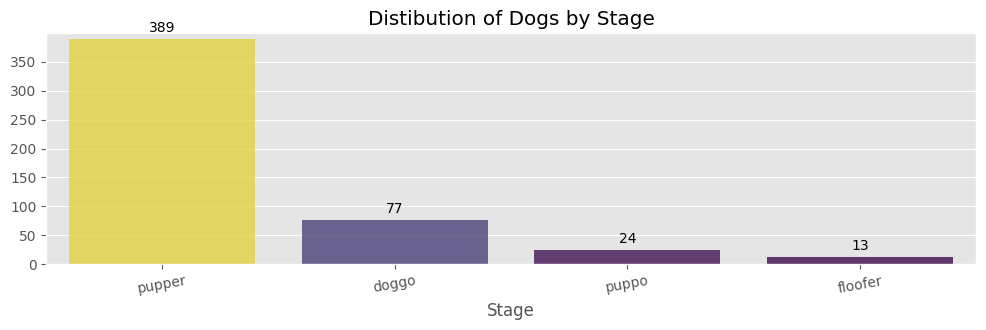

In [144]:
# Plot the Dog Stage Count
plot_attrib(dog_stage,'Stage','Distibution of Dogs by Stage')

Dogs in the pupper stage are the most occuring, followed by doggos.

#### Insight #2: The most Popular Breed

In [218]:
# Get the dog stages count
dog_breed = twitter_archive_final.breed.value_counts()[:10]

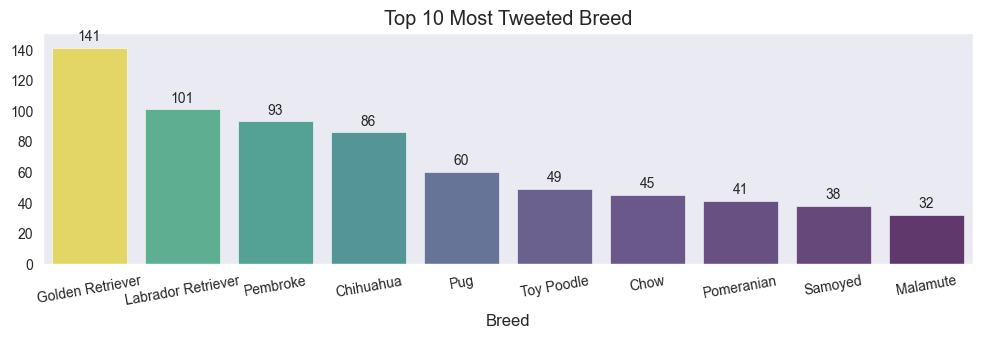

In [220]:
# First, let's plot the distribution of the Top 10 Breed
plot_attrib(dog_breed,'Breed','Top 10 Most Tweeted Breed')

Majority of the dogs displayed in the images are golden retriever, followed by labrador retriever, Pembroke etc.

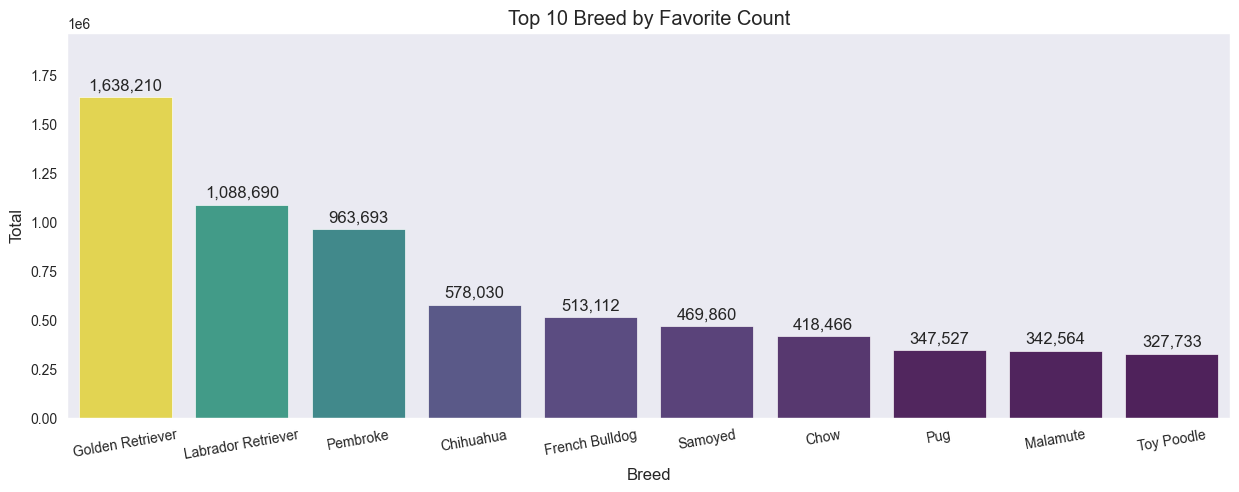

In [236]:
plot_attributes(twitter_archive_final, 'breed','favorite_count','sum')

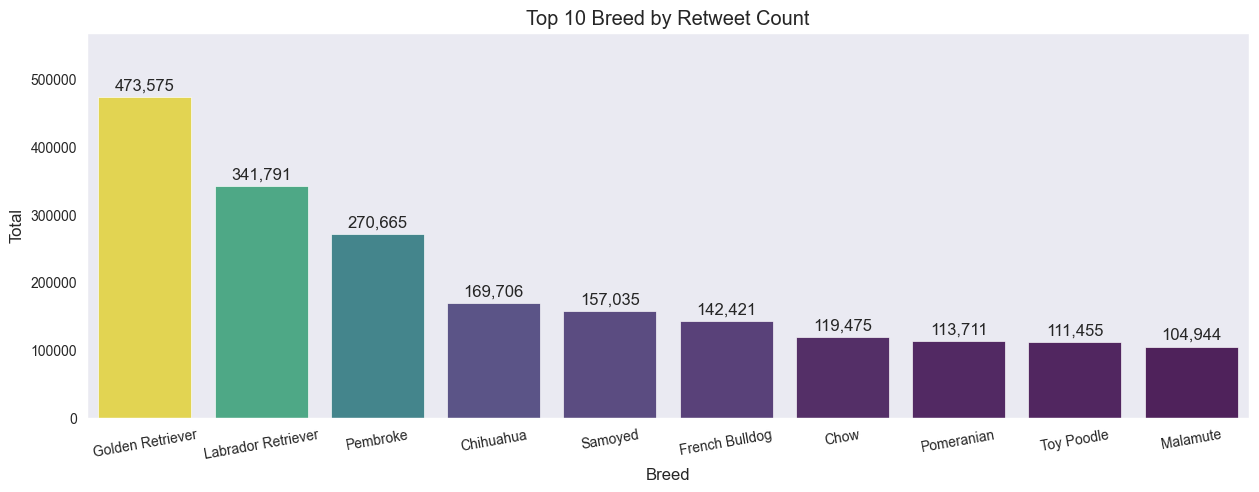

In [237]:
plot_attributes(twitter_archive_final, 'breed','retweet_count','sum')

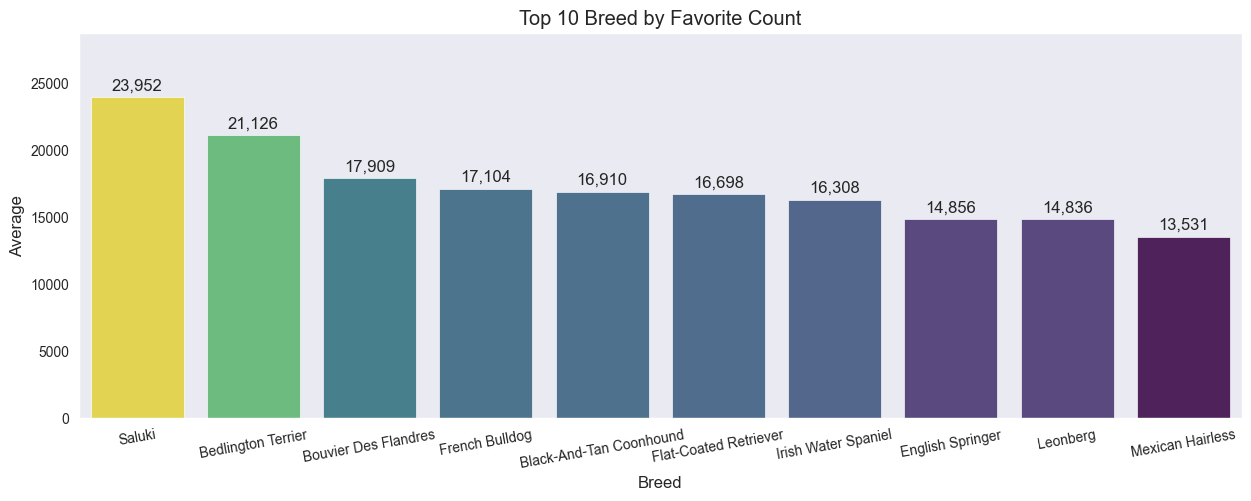

In [238]:
plot_attributes(twitter_archive_final, 'breed','favorite_count','mean')

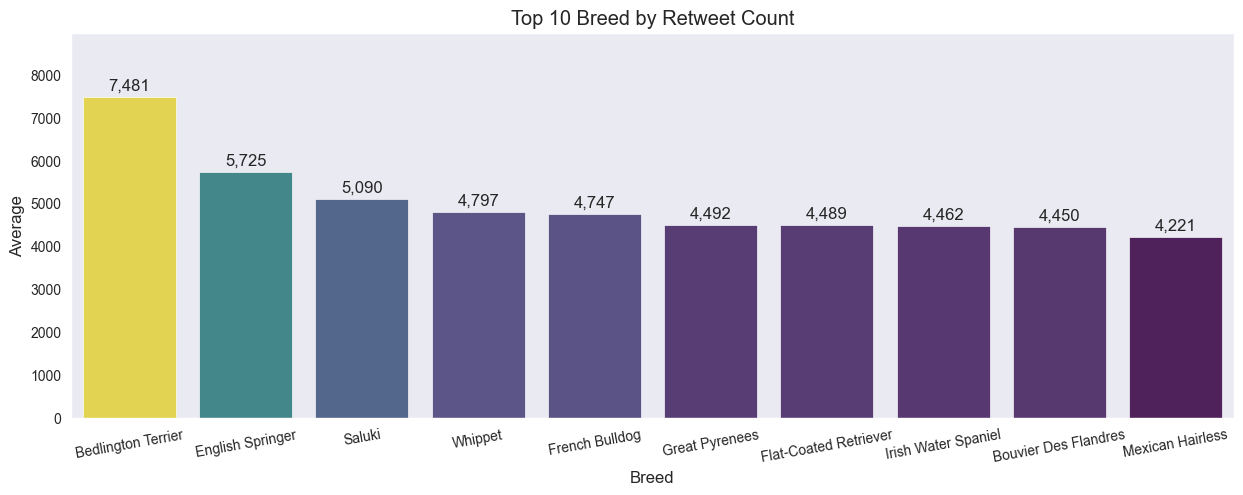

In [239]:
plot_attributes(twitter_archive_final, 'breed','retweet_count','mean')

Whereas Golden Retriever lead the list of breed with most liked tweets and retweet, Saluki has the highest likes per tweet, while Bedlington Terrier experienced the highest retweet per post . Hence, in terms of total likes and retweet, Golden Retriver is the most popular breed on Twitter.

Let's check the dogs with highest likes and retweet

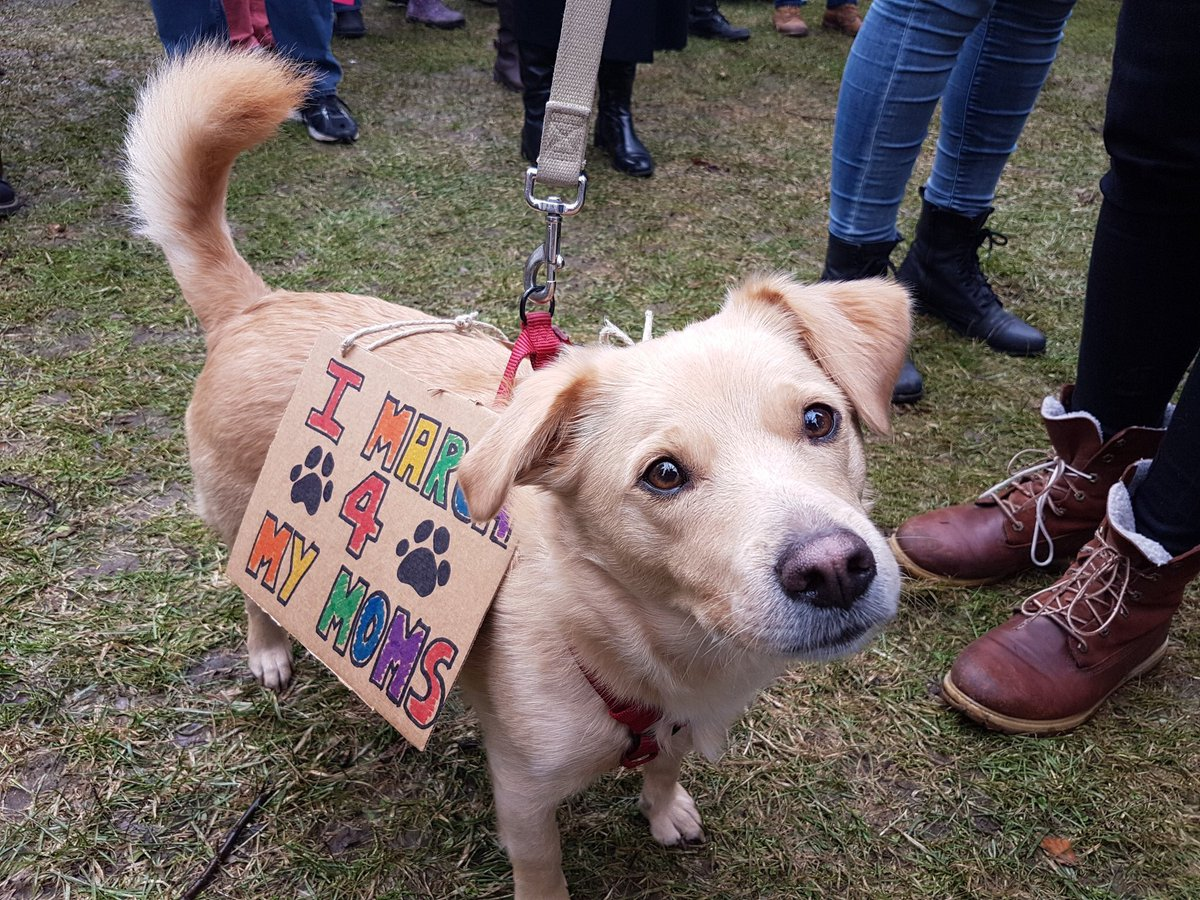

In [245]:
Image(twitter_archive_final['jpg_url'].loc[twitter_archive_final['favorite_count'].idxmax()])

In [248]:
twitter_archive_final['breed'].loc[twitter_archive_final['favorite_count'].idxmax()]

'Lakeland Terrier'

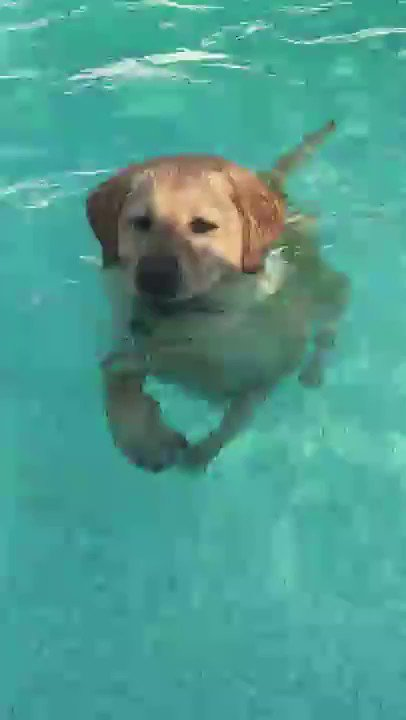

In [249]:
Image(twitter_archive_final['jpg_url'].loc[twitter_archive_final['retweet_count'].idxmax()])

In [250]:
twitter_archive_final['breed'].loc[twitter_archive_final['retweet_count'].idxmax()]

'Labrador Retriever'

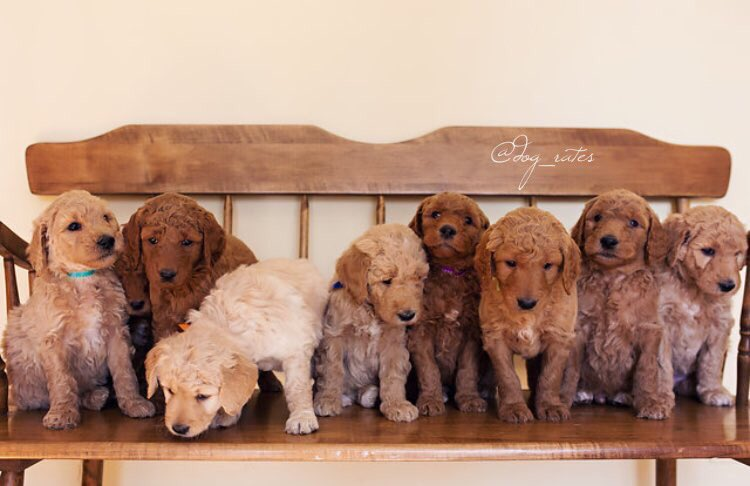

In [257]:
# Below is an image of Golden Retrievers
Image("https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg")

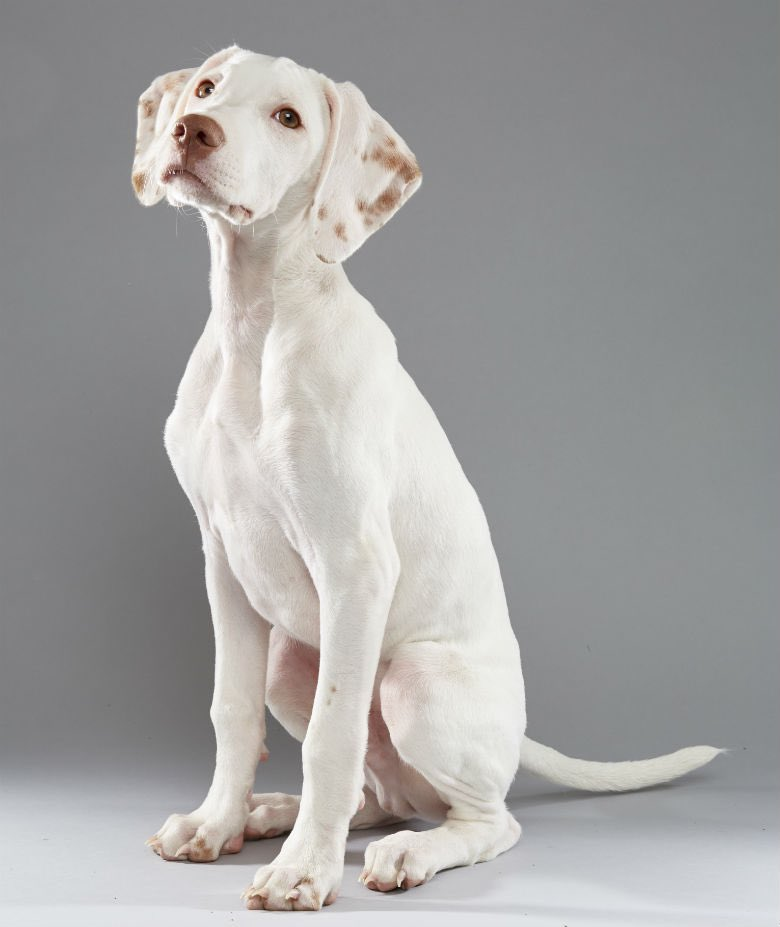

In [258]:
# Below is an image of a Bedlington Terrier
Image("https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg")

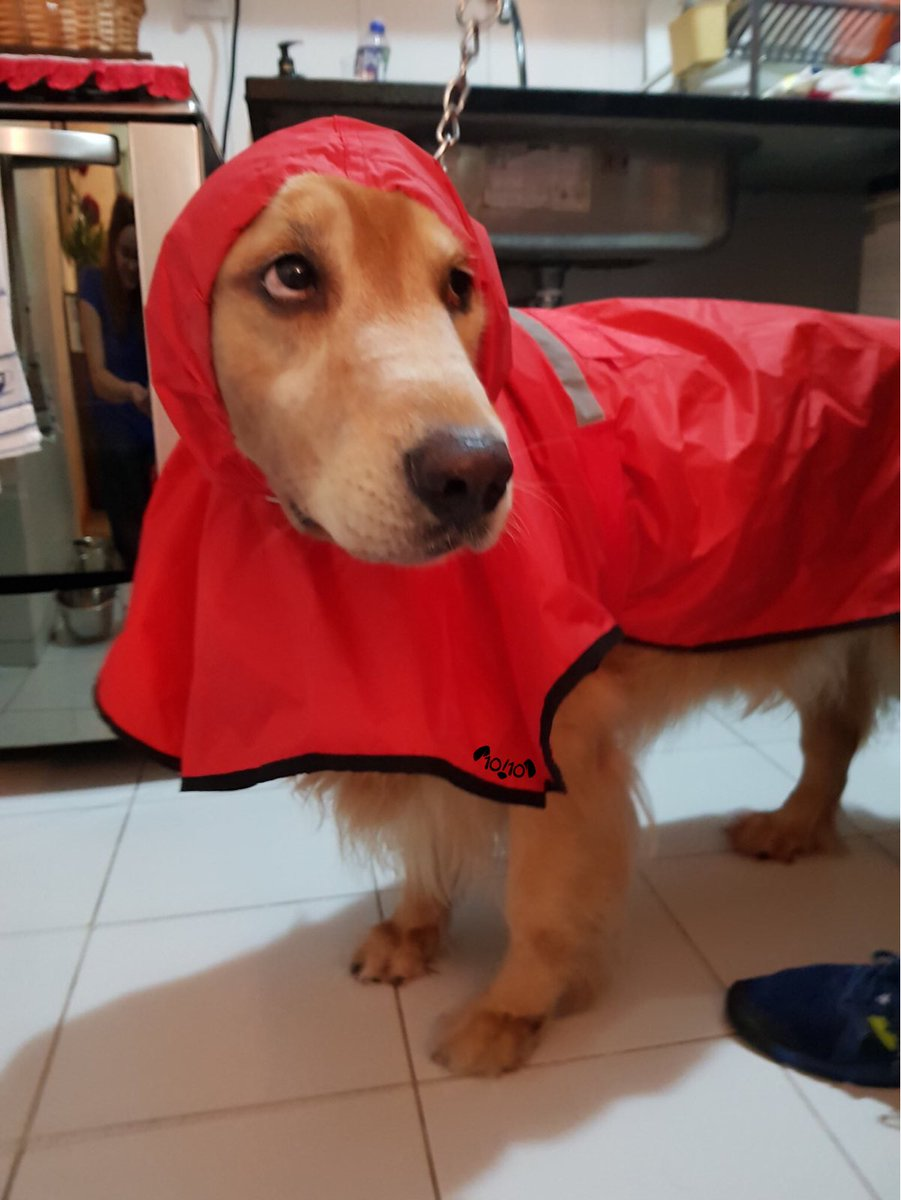

In [264]:
# Below is an image of a Saluki
Image("https://pbs.twimg.com/media/DCza_vtXkAQXGpC.jpg")

#### Insight #3: Engagement Frequency of the "WeRateDog" account

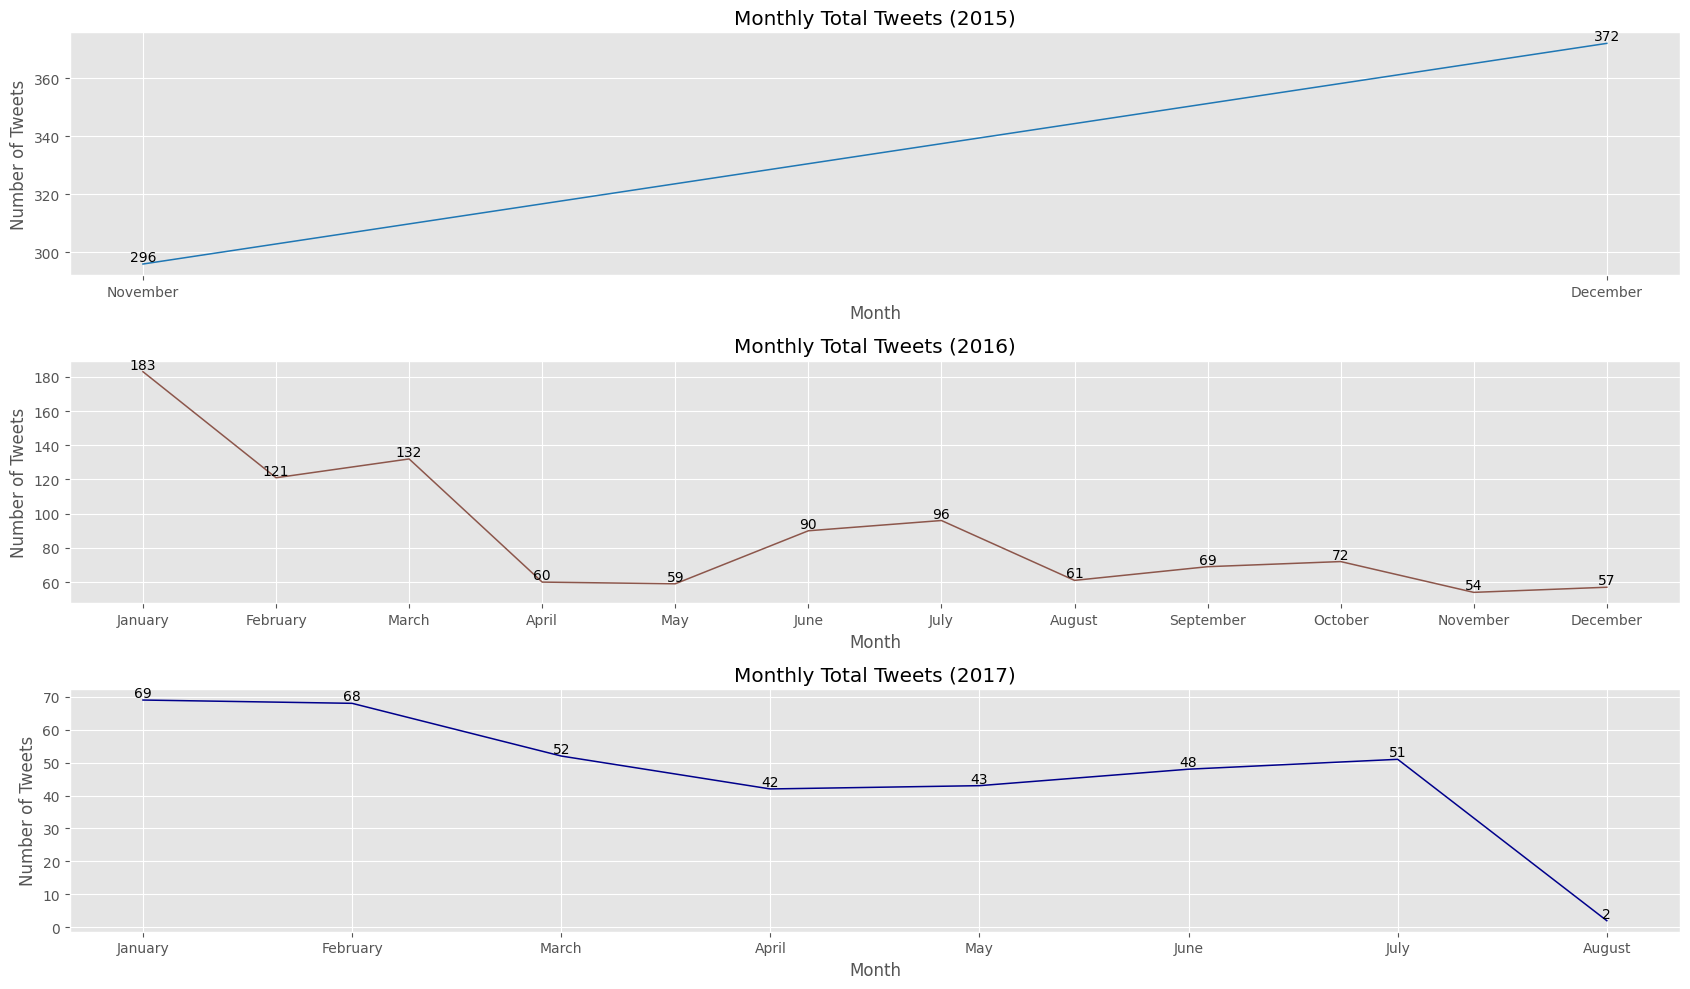

In [18]:
# Plot Monthly Tweet by year for the WeRateDod Account
plot_period(twitter_archive_final,'monthly')

Highest monthly tweet was recorded in December 2015, a month after the account was opened.

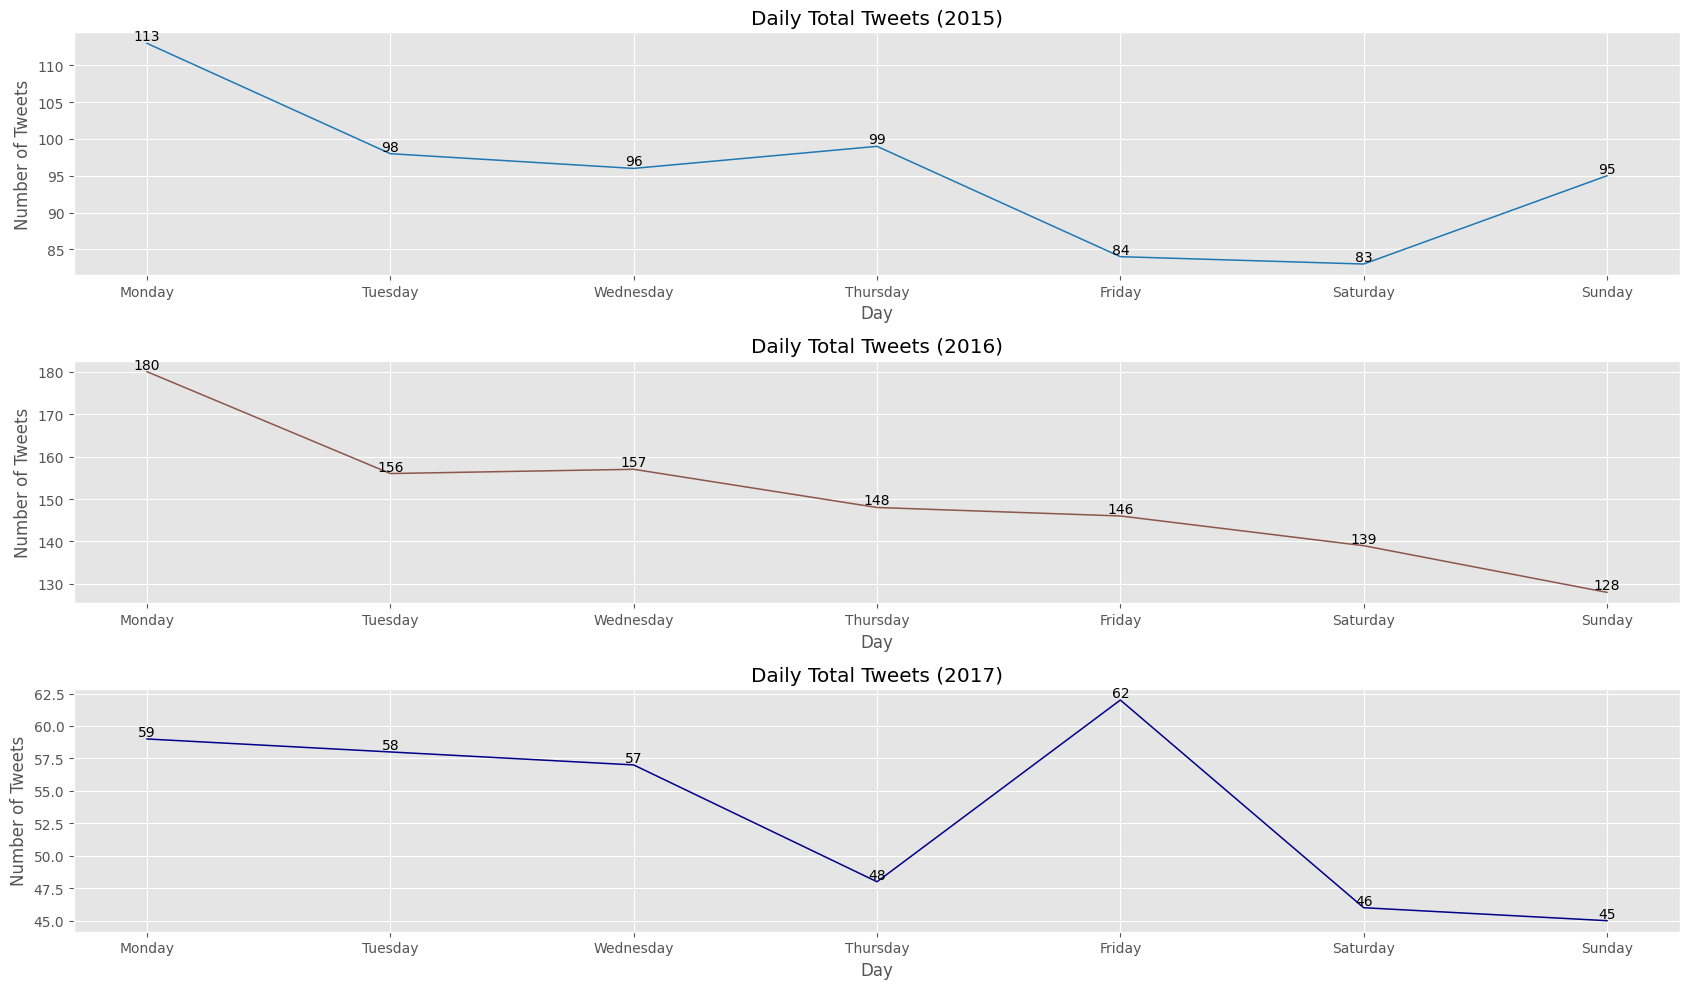

In [19]:
# daily Activities
plot_period(twitter_archive_final,'daily')

Accross the year, Monday seems the most busy day of the account

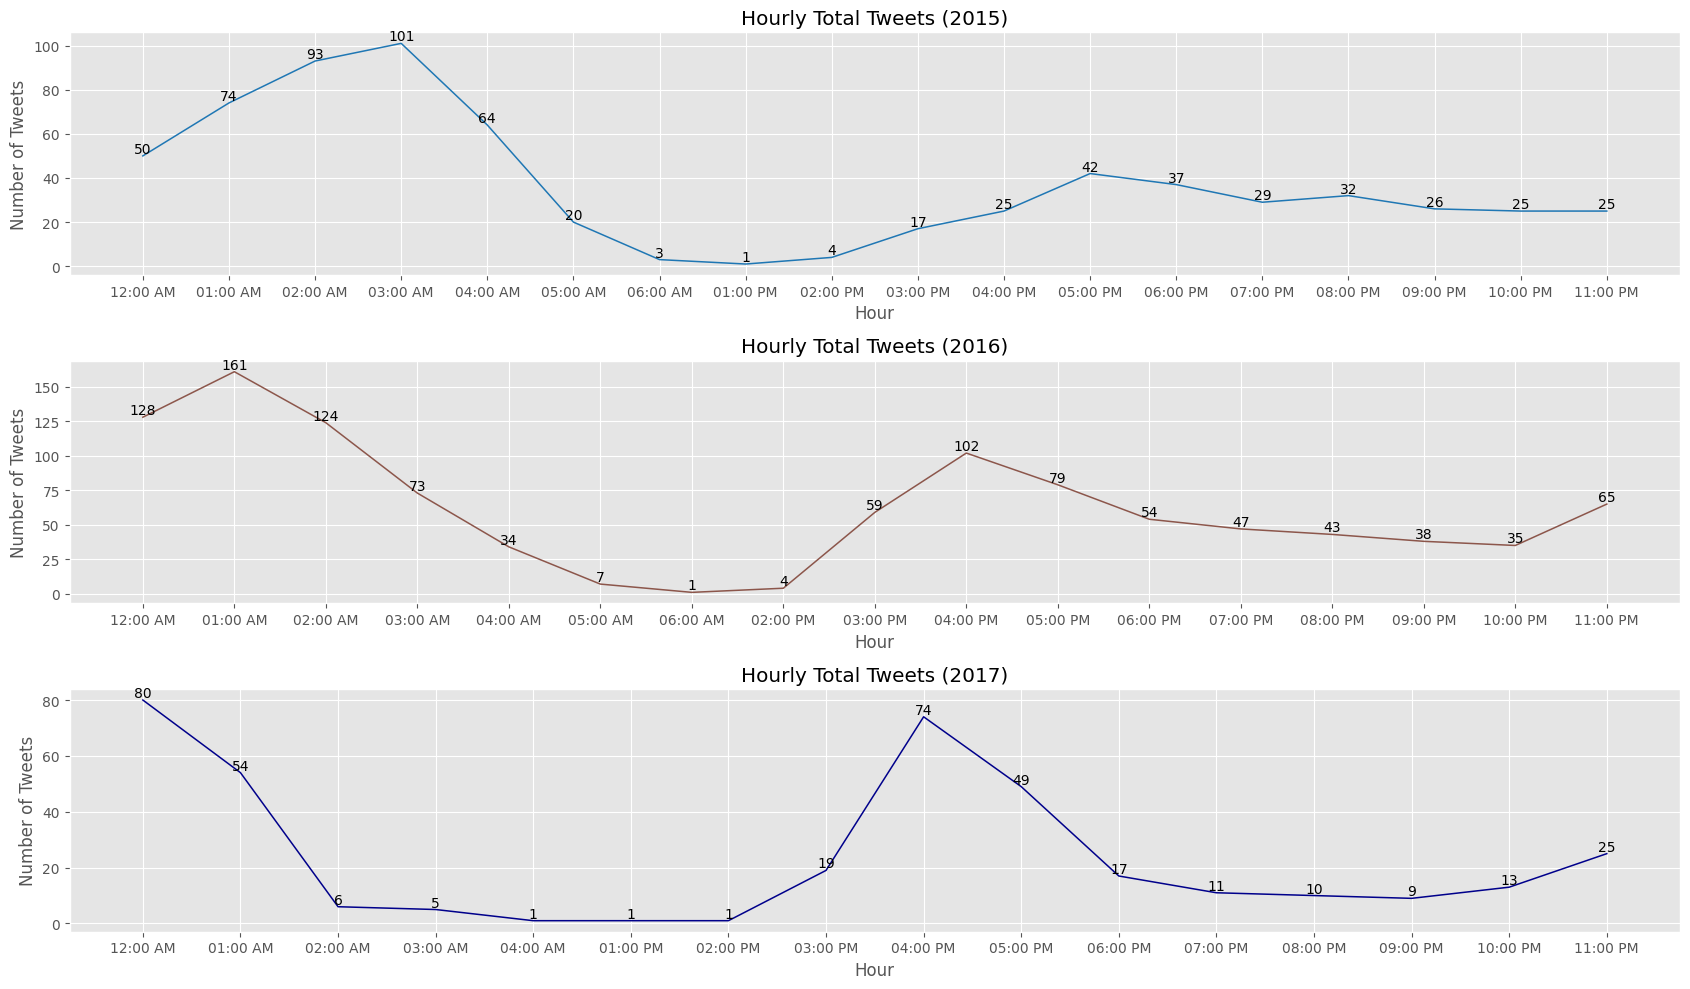

In [20]:
#plot Hourly Activity of the account by year
plot_period(twitter_archive_final,'hourly')

The above shows that people Like to interract with the WeRateDog account in the early midnight of the day, and its lowest during the day and become high again between 4PM to 5PM. This is undesrtandable as most people become less active on the internet during work hours.

#### Insight #4. Relationship Between Posts Retweeting & Favourism

In [206]:
# Let's remove outliers from the rating, to overide the effect of outliers
rating_data = discard_outliers(twitter_archive_final,'rating')

Text(0, 0.5, 'Favorite Count')

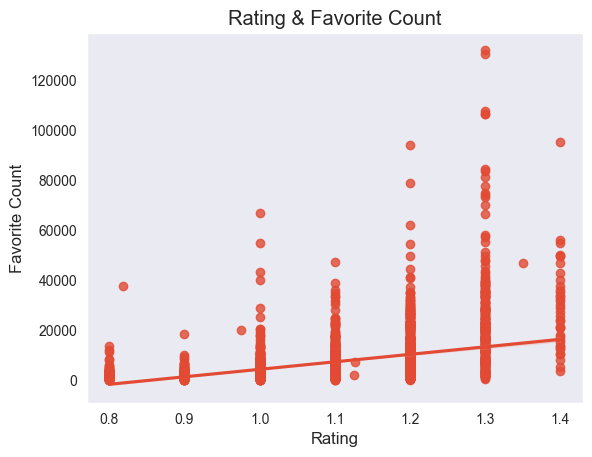

In [166]:
sns.set_style('dark')
ax=sns.regplot(x='rating',y='favorite_count', data=rating_data,robust=True)
plt.title('Rating & Favorite Count')
plt.xlabel('Rating')
plt.ylabel('Favorite Count')

In [29]:
rating_data[['rating', 'favorite_count']].corr()

,rating,favorite_count
rating,1.000000,0.484845
favorite_count,0.484845,1.000000


The Pearson's r of rating and favorite count is around 0.5, which means there is a moderately positive correlation between the variables. This implies that ratings somewhat reflect people's preferences for dogs.

Let's look at the top/worst rated dogs

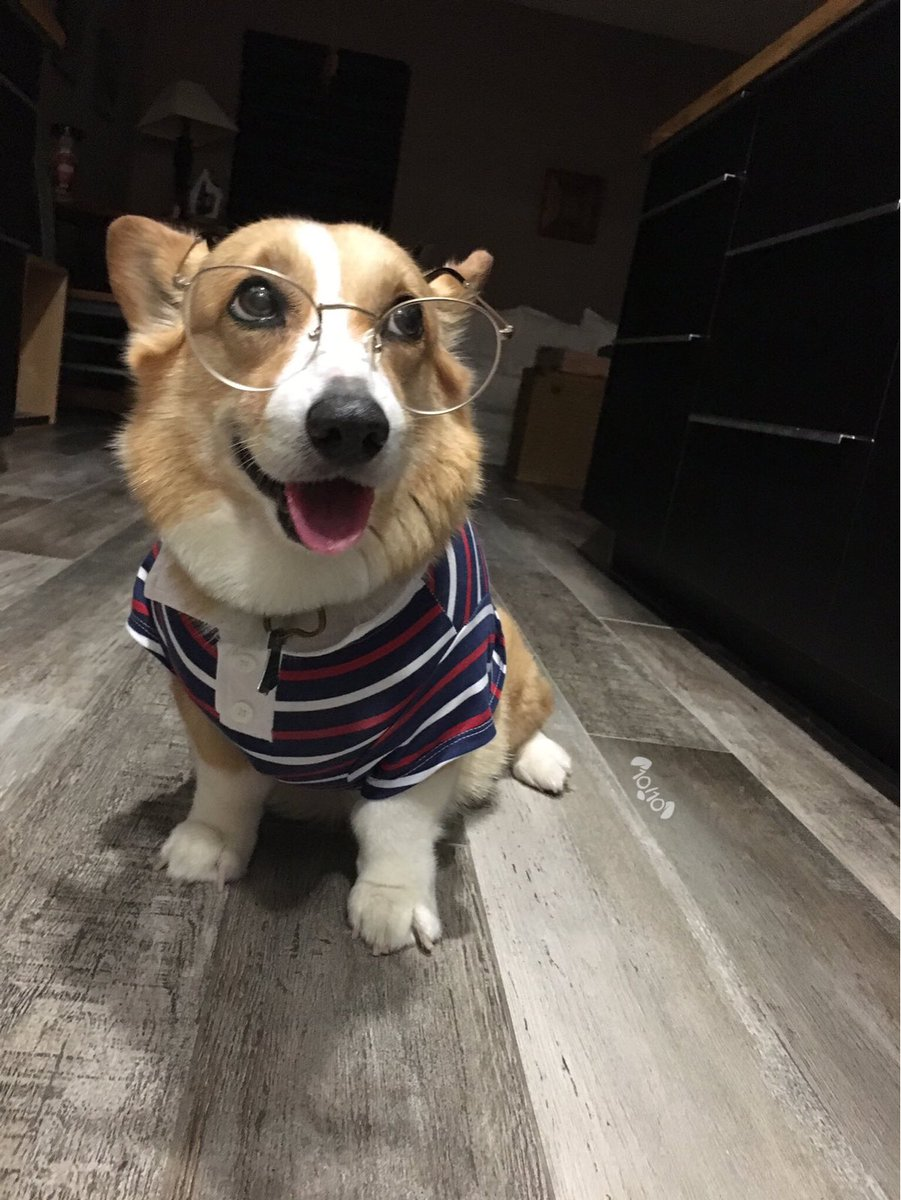

In [244]:
# Top Rated Dog
Image(rating_data['jpg_url'].loc[rating_data['rating'].idxmax()])

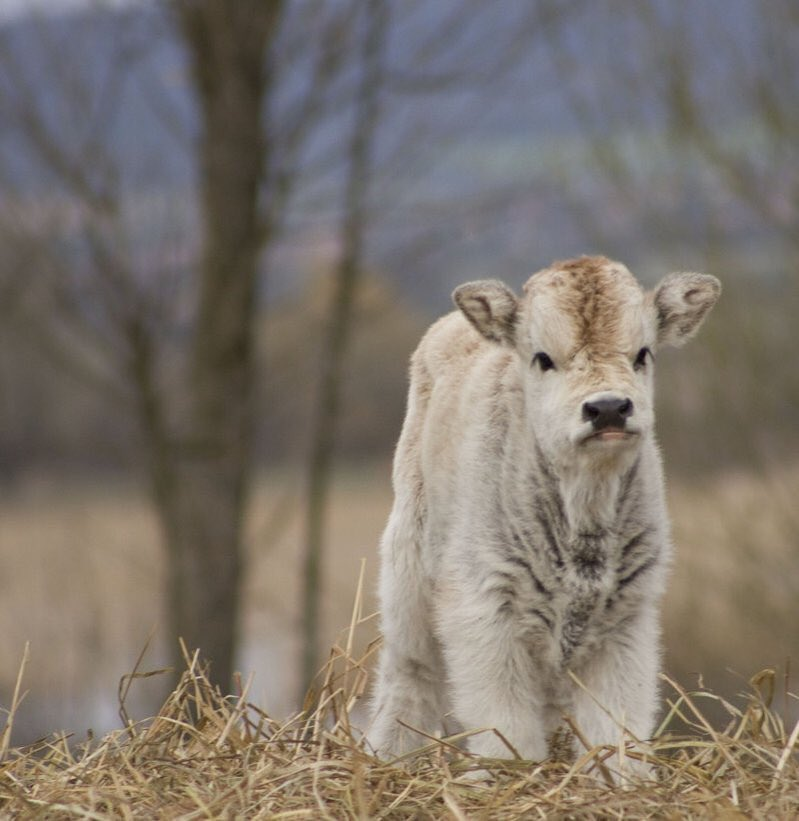

In [243]:
# Worst Rated Dog
Image(rating_data['jpg_url'].loc[rating_data['rating'].idxmin()])

#### Insight #5. Influence of Post Retweeting on Number of Times a Post is Liked

Text(0, 0.5, 'Likes')

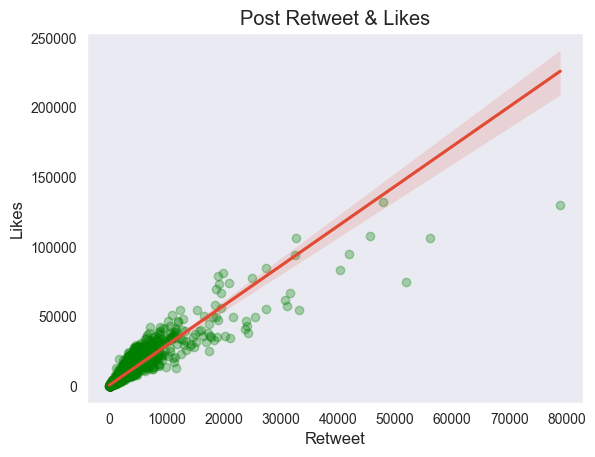

In [31]:
sns.set_style('dark')
sns.regplot(data = rating_data, x="retweet_count", y="favorite_count",robust=True, scatter_kws = {'color': 'Green', 'alpha': 0.3})
plt.title('Post Retweet & Likes')
plt.xlabel('Retweet')
plt.ylabel('Likes')

In [387]:
rating_data[['retweet_count', 'favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.912643
favorite_count,0.912643,1.000000


There is a strong positive linear relation between post retweet and number of time a post receives likes. This implies that people who like a post are highly likely to retweet and vice versa.

In [217]:
rating_data.loc[:, 'date'] = pd.to_datetime(rating_data['timestamp']).dt.date

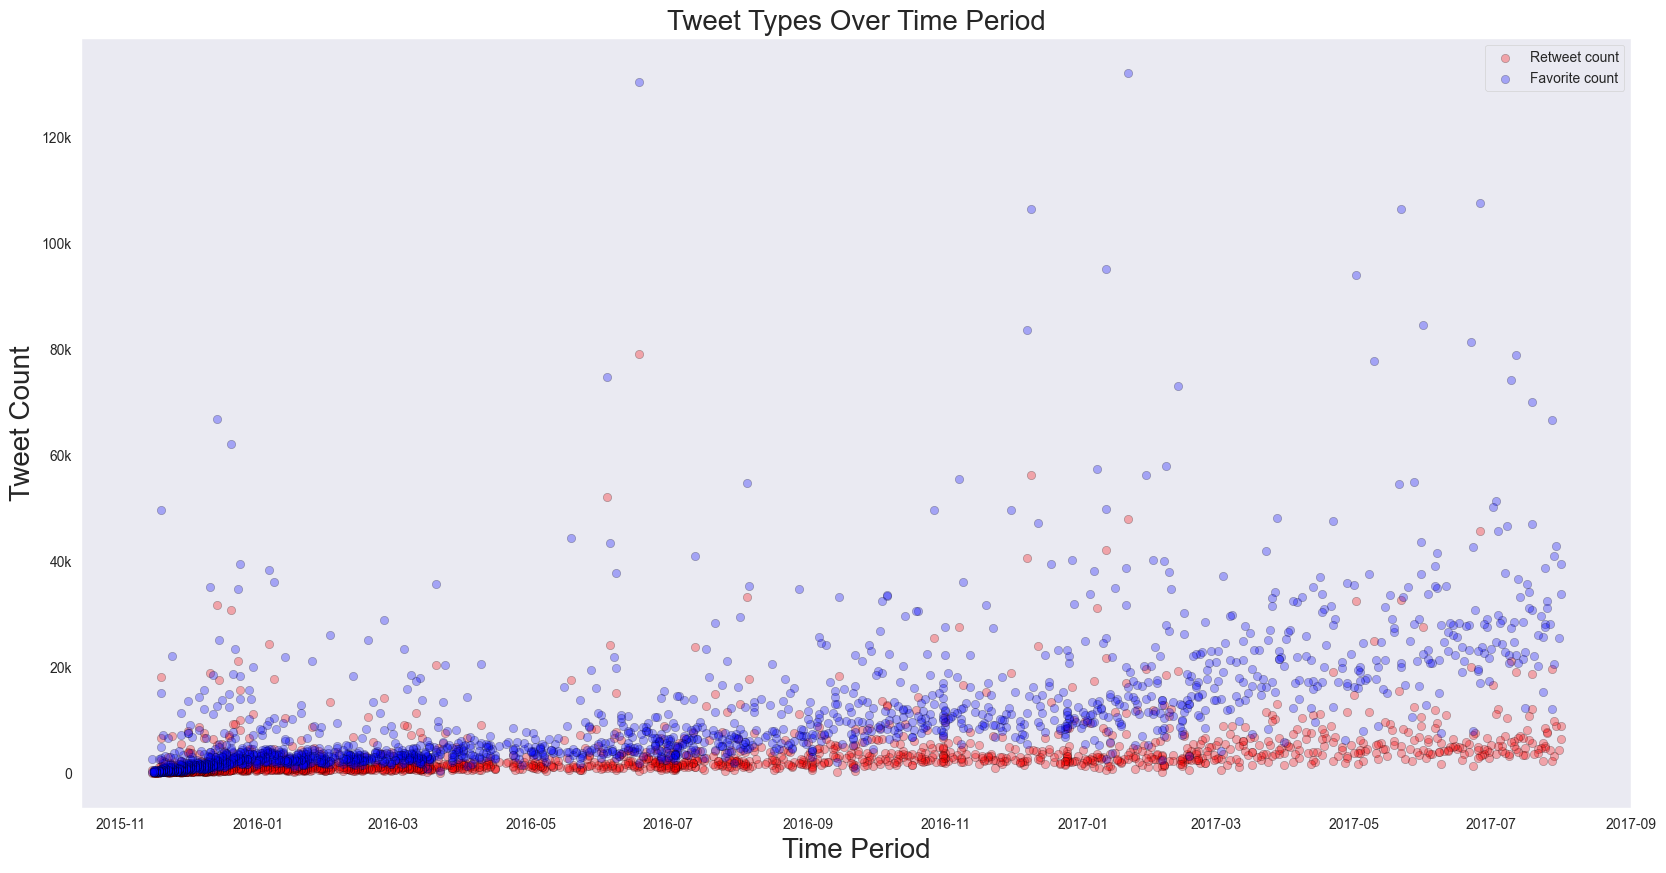

In [216]:
# Create a scatter plot with retweet count
plt.figure(figsize=(20, 10))
sns.scatterplot(x='date', y='retweet_count', data=rating_data, 
                color='red', edgecolor='k', alpha=0.3, label='Retweet count')

# Create a scatter plot with favorite count
sns.scatterplot(x='date', y='favorite_count', data=rating_data, 
                color='blue', edgecolor='k', alpha=0.3, label='Favorite count')

# Adding labels and title
plt.xlabel('Time Period', fontsize=20)
plt.ylabel('Tweet Count', fontsize=20)
plt.title('Tweet Types Over Time Period', fontsize=20)
plt.yticks([0,20000,40000,60000,80000,100000,120000],
           ['0','20k','40k','60k','80k','100k','120k'])
plt.legend()

### Conclusion

In this project, I completed a data wrangling process by

* gathering data from a variety of on and offline sources and in a variety of formats. The main dataset Enhance Twitter Archive which is provisioned by Udacity, contains dog ratings from the popular Twitter WeRateDogs rating provider. However, it was missing important elements like favorite and retweet counts, which fortunately can be scraped from Twitter site via an API provisioned by Twitter. Nonetheless, Twitter site is constantly aging out old tweets, so some of the required entries are no longer available for scrapping. To get around this, we resorted to loading an archived version of Twitter dataset tweet_json.txt provisioned by Udacity. Udacity also provisioned another dataset Image Predictions File that can be used to run every image from the Enhance Twitter Archive to get the top 3 predictions of the dog breed, providing the image is not older than August 1, 2017.

* secondly, assessing the data visually and programmatically to identify potential data tidiness and quality issues that would be obscuring any meaningful data insight. All the issues identified were documented for cleaning.

* thirdly, cleaning the data issues documented. Each issue was prescribed a code fix, followed by execution and testing of the code fix.

* Forthly, consolidating the 3 cleansed datasets into one single master dataset and storing it to a csv file and a python SQLite.

*Lastly, loading the master dataset and conducting various data analysis and visualization on the wrangled data to produce a report documenting the wrangling efforts and another, communicating insights from the dataset